## Test Markdown for Task 1

We present a novel dataset based on Sentinel-2 satellite images covering <span style="color:blue; font-weight:bold;">13 spectral bands</span> and consisting of <span style="color:blue; font-weight:bold;">10 classes with 2 to 3k per class</span> in total <span style="color:blue; font-weight:bold;">27,000 labeled and geo-referenced images</span>. We provide benchmarks for this novel dataset with its spectral bands using state-of-the-art deep Convolutional Neural Network (CNNs). With the proposed novel dataset, we achieved an overall classification accuracy of <span style="color:red; font-weight:bold;">98.57%</span>. The resulting classification system opens a gate towards a number of Earth observation applications. We demonstrate how this classification system can be used for detecting land use and land cover changes and how it can assist in improving geographical maps. The geo-referenced dataset EuroSAT is made publicly available here.

Things to understand:
- Spectral bands - different ranges of wavelengths of light that are captured by a satellite sensor
- 10 classes
- Labeled and geo-referenced images
- CNNs
- Why is land use and cover classification relevant?
- supervised machine learning
-  mutli-spectral image data provided by the Sentinel-2A satellite 

## Spectral Bands and Classes
<img title="a title" alt="Alt text" src="Images/spectral_bands.png" width="250" height="200"> <img title="a title" alt="Alt text" src="Images/sample_image_patches.png" width="350" height="200">

The three bands B01, B09 and B10 are intended to be used for the correction of atmospheric effects(e.g., aerosols, cirrus or water vapor). The remaining bands are primarily intended to identify and monitor land use and land cover classes.

## Classification Accuracy

<img title="a title" alt="Alt text" src="Images/classification_accuracy_train_test.png" width="600" height="250"> <img title="a title" alt="Alt text" src="Images/classification_accuracy_best.png" width="350" height="200"> <img title="a title" alt="Alt text" src="Images/classification_accuracy_resnet.png" width="200" height="200">

Notes
- The aim of land use and land cover classification is to automatically provide labels describing the represented physical land type or how a land area is used
- Data only covers EU countries
- In order to improve the chance of getting valuable image patches, we selected satellite images with a low cloud level. Besides the possibility to generate a cloud mask, ESA provides a cloud level value for each satellite image allowing to quickly select images with a low percentage of clouds covering the land scene

## Tips for High Marks
- Explore different models in sklearn beyond those covered in class
  - Describe conclusions
  - Use different metrics and see what you observe (Dont just add all, understand why and show it)
- Visualisation examples
    - Understand how well your model and feature selection works
    - Start with a qn -> hypotheses -> Then BAM
- Use functions as much as possible, minimal classes
- Print images, accuracies, etc as much as possible (So grader can glance)
- NO PANDAS
- Run and save notebook using Pickl (?) so on appear, they can see everything
- Technical mastery of module curriculum This include illustration/utilization of items like CV, proper training/testing protocols and
visualizations where appropriate.

## Dont's for Low Marks
- Perform pre-processing steps we haven't covered like noise/outlier removal
  - Wont get you additional marks
- Hyperparameter optimisation -> Explain I am trying to optimise this parameter, this is what it does, and these are the values ive tried
  - You can do this manually by looking at a range of values
  - Describe the quantities you are optimising
  - There are systematic methods like GridSearchCV, DONT USE! 
--------

## Task 1
This notebook focuses on getting the given dataset ready for developing machine learning models through pre-processing and transformation. The top 10 most important features are identified using pearson correlation and then used to build an SVM classifier, which was then holistically evaluated.

<p style="font-style: italic;">Note - In each step, there were multiple methods of implementation that were tried hence, the addiditonal code for each section. For example: For normalisation, three different types were used for experimentation</p>



Write a Python program to pre-process and transform the dataset into a format suitable for developing machine learning models. Use pearson correlation method to identify ten most important features. Use these features to build a SVM classifier and evaluate your model’s performance.

<span style="font-weight:bold;">Save your response (program and markdown) as task1.ipynb.</span>

In [1]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from functions.pre_processing import *
from functions.transformations import *
from functions.feature_selection import *
from functions.analysis import *
from functions.classifiers import *
from functions.model import *
from functions.evaluation import *
from sklearn.metrics import accuracy_score

In [2]:
x_train, x_test, y_train, y_test = fetch_datasets()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16200, 512)
(5400, 512)
(16200,)
(5400,)


-----------------------------------------------------------------
## Pre-Processing and Transformation

The pre-processing stage consisted of trying to find outliers in the train and test sets. Outliers were defined as features with no unique values or values that weren't numeric/missing. Thorugh analysis, it was found that no outliers exist hence why techniques like `Imputation` was not used as it is only relevant for handling missing values.

Visualisations were added to see the split of values and identify how data was spread out and whether there was a skew towards specific value. If there was a skew, the hypothesis was that this could be affecting the model's performance towards a specific class.

Conclusion - It can be seen that there are no outliers amongst the features and classes


No features with 1 unique value
Missing Values in x_train -> 0, Missing Values in x_test -> 0
Missing Values in y_train -> 0, Missing Values in y_test -> 0


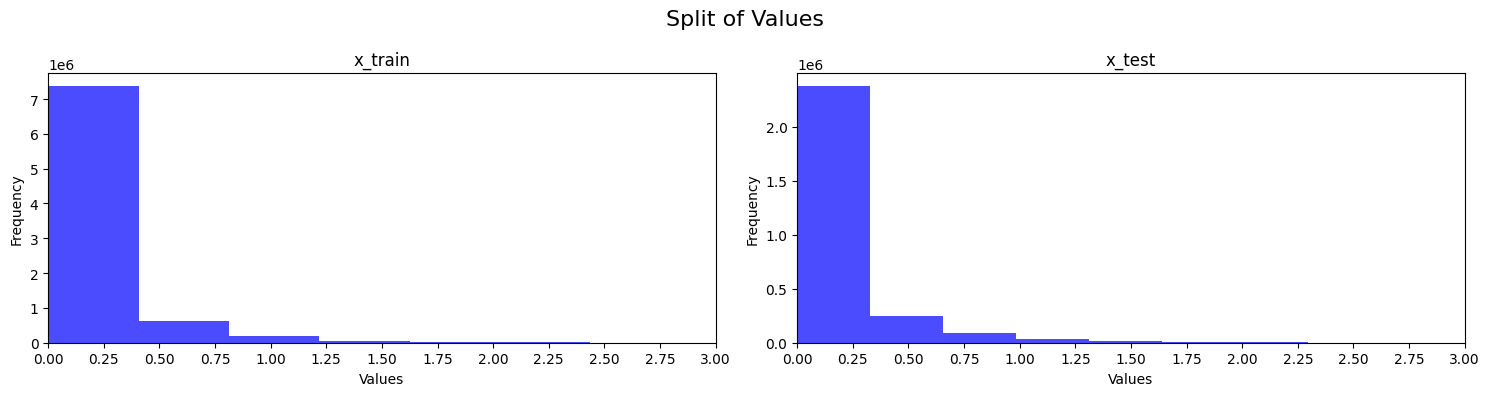

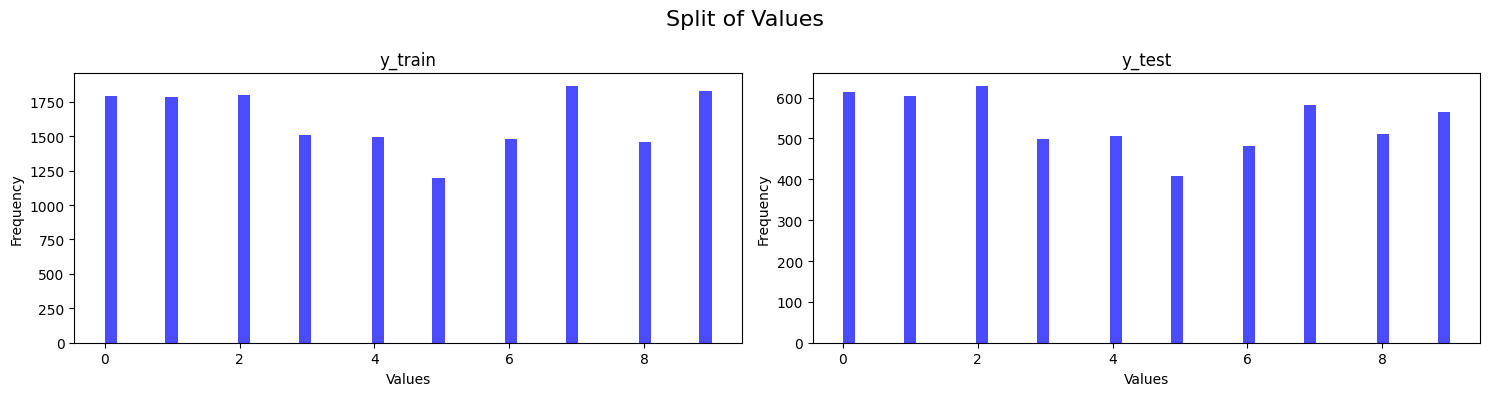

In [3]:
'''
Try different techniques of pre processing and transformation and see the difference in results?
'''

# Checking for unique values of feature, there were 0 features in the train set with more than 1 unique value
# In the test set, there was one feature with 2 unique values, but I chose to keep this as if this feature has strong correlation with the target variablee, it could still be useful
num_features = x_test.shape[1]
unique_value_counts = [len(np.unique(x_test[:, i])) for i in range(num_features)]
filtered_features = [(i+1, count) for i, count in enumerate(unique_value_counts) if count == 1]

if len(filtered_features) == 0:
    print("No features with 1 unique value")
else:
    for feature, count in filtered_features:
        print("Features with less than 100 unique values:")
        print(f"Feature {feature}: {count} unique values")

# Checking for missing values
print(f"{find_missing_values(x_train, "x_train")}, {find_missing_values(x_test, "x_test")}")
print(f"{find_missing_values(y_train, "y_train")}, {find_missing_values(y_test, "y_test")}")

plot_feature_split_of_values([x_train, x_test], ["x_train", "x_test"])
plot_class_split_of_values([y_train, y_test], ["y_train", "y_test"])

# Tried removing scientific notation from numbers to see if that would present difference split of outputs (for features only) - this made no difference
# for i in range(len(x_train)):
#     for x in range(len(x_train[i])):
#         x_train[i][x] = '{:.8f}'.format(x_train[i][x])

# for i in range(len(x_test)):
#     for x in range(len(x_test[i])):
#         x_test[i][x] = '{:.8f}'.format(x_train[i][x])

-----------------------------------------------------------------
## Normalisation

As seen from the split of data above, the feature train and test datasets had a range between 0 and 2.5. To ensure features were on a similar scale, normalisation was used. Multiple types of scaling was experimented with - (i) Min Max, (ii) Standardisation, and (iii) Robust Scaler. The hypotheses tested with each is mentioned below.

1. <b>Min Max <span style="color: darkgreen;">[Best Performance]</span></b> - Scales the data to a fixed range (in this case, [-1, 1]) [1]. As no outliers were detected, this was used to linearly scale the features down to a defined range and presented the best testing accuracy.<span style="font-style: italic;">

2. <b>StandardScaler</b> - Scales the data based on the mean and standard deviation, so that each have values of 0 and 1 respectively. MinMaxScaler was used over StandardScaler as (i) the testing accuracy was better and (ii) the upper and lower bound of values were known.

3. <b>RobustScaler</b> - RobustScaler scales the data based on statistics and percentiles, protecting it against outliers unlike the above two methods [3]. Since there were no outliers in this dataset, it was not needed.

<span style="font-style: italic;">PS: Would not use MinMax or StandardScaler if outliers were detected as it is very sensitive to the presence of outliers</span>

datasets/task1/x_train has the new model!
datasets/task1/x_test has the new model!
datasets/task1/y_train has the new model!
datasets/task1/y_test has the new model!


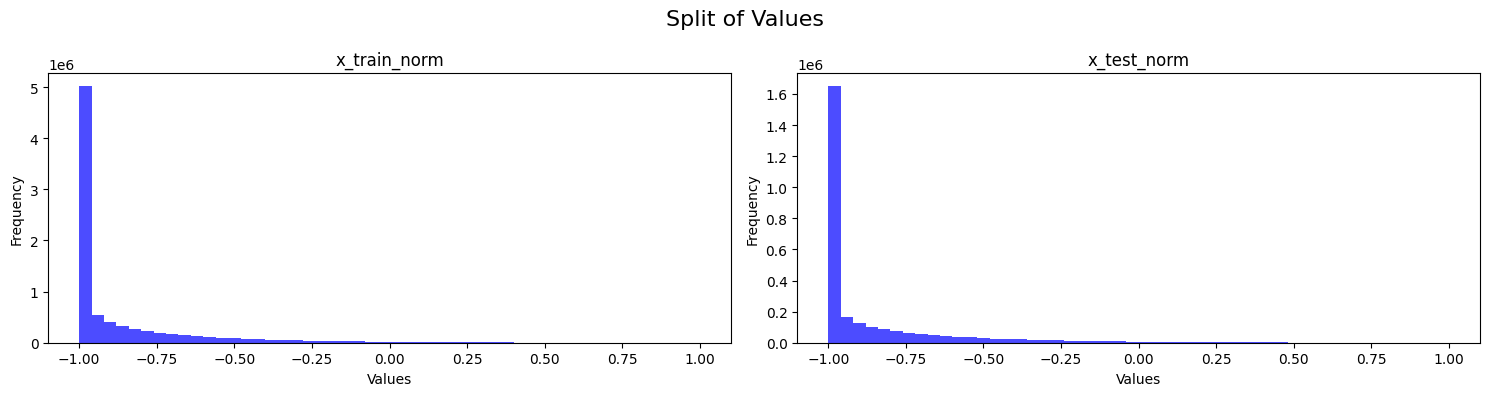

In [4]:
# ------- TRANSFORMATION ---------
x_train_norm, x_test_norm = normalise_min_max(x_train, x_test)

# x_train_norm, x_test_norm = normalise_std_scaler(x_train, x_test) # Best configuration - Training Accuracy: 0.5945061728395061 | Testing Accuracy: 0.5559259259259259

# x_train_norm, x_test_norm = normalise_robust_scaler(x_train, x_test) # Best configuration - Training Accuracy: 0.5701234567901234 | Testing Accuracy: 0.5364814814814814

save_model(x_train_norm, "datasets/task1/x_train")
save_model(x_test_norm, "datasets/task1/x_test")
save_model(y_train, "datasets/task1/y_train")
save_model(y_test, "datasets/task1/y_test")

# Split of values after normalisation
plot_class_split_of_values([x_train_norm, x_test_norm], ["x_train_norm", "x_test_norm"])

--------
# A visualization should have a goal/question/hypothesis. Clarify this!

## Feature Selection

This section goes over the feature selection processs of getting the top 10 features using Pearson correlation. The features of this set are all numerical as these are the extracted features from the input images. Due to this, it was assumed that the features did not consist of any order (Ordinal).

The aim of this section was to (i) Find and eliminate 

## Variance Threshold?

[178 479 136 369 254 440  38 485 116  64]


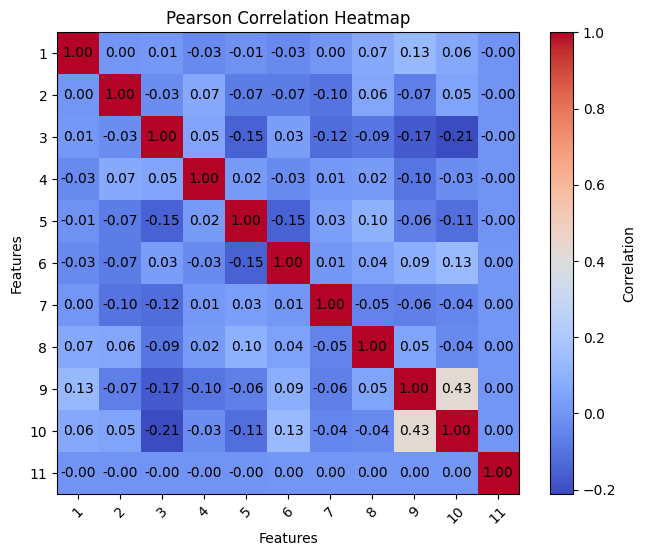

In [5]:
# ------- FEATURE SELECTION ---------
feature_correlation = pearson_correlation(x_train_norm, y_train)
print(f"The top 10 features are -> {feature_correlation[:10]}")

top_features_indices = feature_correlation[:10]
selected_features = x_train_norm[:, top_features_indices]
correlation_matrix = np.corrcoef(selected_features.T, y_train)

plot_correlation_heatmap(correlation_matrix)

-----------------------------------------------------------------
## Training + Cross Validation

Support Vector Classification (SVC) is used over Support Vector Regression (SVR) as the dataset is use for classification, hence favoring SVC being used.

mention why the different types of testing were used 
<h3 style="text-weight: bold;">Mention why not used resubstitution and why used each testing method</h3>
Leave one out CV?

In [9]:
# What does the C hyperparameterisation do?
# What parameters can be optimised in SVC

# ----- WHY EACH ONE USED
svc_results = svc_classifier(x_train_norm[:, top_features_indices], x_test_norm[:, top_features_indices], y_train, y_test)
# svc_results_cv = svc_classifier(x_train_norm[:, top_features_indices], x_test_norm[:, top_features_indices], y_train, y_test, "cv")
# svc_results_k_fold = svc_classifier(x_train_norm[:, top_features_indices], x_test_norm[:, top_features_indices], y_train, y_test, "k_fold")
# svc_results_k_fold_strat = svc_classifier(x_train_norm[:, top_features_indices], x_test_norm[:, top_features_indices], y_train, y_test, "k_fold_strat")

------ Holdout Validation ------
Training Accuracy: 0.5920987654320987
Testing Accuracy: 0.5607407407407408
------ Cross Validation ------
Mean Accuracy: 0.5587037037037037
------ K fold Validation ------
Mean Accuracy: 0.5620833333333334
Std Deviation: 0.009529505296363275
------ Stratified K fold Validation ------
Mean Accuracy: 0.5626388888888889
Std Deviation: 0.010009105079841764


In [6]:
save_model(svc_results, "models/task1/svc_results")
# save_model(svc_results_cv, "models/task1/svc_cv")
# save_model(svc_results_k_fold, "models/task1/svc_training_k_fold")
# save_model(svc_results_k_fold_strat, "models/task1/svc_training_k_fold_strat")

models/task1/svc_results has the new model!


-----------------------------------------------------------------
## Hyperparameter Optimisation [Create a table showing the split of responses]
Mention tried different params to increase margin between train test accuracy, increasing accuracy but risking overfitting

In [7]:
# Hyperparameter optimisation (params is like .fit(x_train, x_test), hyperparams are like whats inside SVC())
c_values = [1, 10, 50, 100]
kernels_values = ["linear", "rbf", "poly", "sigmoid"]
gamma_values = ["scale", "auto", 0.01, 0.1]

selected_c = 0 
selected_kernel = ''
selected_gamma = '' 
best_training = 0
best_test = 0

# Nested CV use here 

for values in range(len(kernels_values)):
     for c_vals in range(len(c_values)):
          for g_values in range(len(gamma_values)):
               svc_clf = SVC(C=c_values[c_vals], gamma=gamma_values[g_values], kernel=kernels_values[values])
               svc_clf.fit(x_train_norm[:, feature_correlation[:10]], y_train)
               current_train = svc_clf.score(x_train_norm[:, feature_correlation[:10]], y_train) 
               current_test = svc_clf.score(x_test_norm[:, feature_correlation[:10]], y_test)

               if (current_train > best_training) and (current_test > best_test):
                    best_training = current_train
                    best_test = current_test
                    selected_c = c_values[c_vals]
                    selected_kernel = kernels_values[values]
                    selected_gamma = gamma_values[g_values]

               print(f"------- With C={c_values[c_vals]}, gamma={gamma_values[g_values]}, kernel={kernels_values[values]}")
               print(f"Training Accuracy - {current_train} | Testing Accuracy - {current_test}")
               # print(f"------- With C={c_values[c_vals]}, gamma={gamma_values[g_values]}, kernel={kernels_values[values]} -------")
               # print(f"Training Accuracy - {}")
               # print(f"Test Accuracy - {}")

------- With C=1, gamma=scale, kernel=linear
Training Accuracy - 0.4924074074074074 | Testing Accuracy - 0.48907407407407405
------- With C=1, gamma=auto, kernel=linear
Training Accuracy - 0.4924074074074074 | Testing Accuracy - 0.48907407407407405
------- With C=10, gamma=scale, kernel=linear
Training Accuracy - 0.49703703703703705 | Testing Accuracy - 0.49166666666666664
------- With C=10, gamma=auto, kernel=linear
Training Accuracy - 0.49703703703703705 | Testing Accuracy - 0.49166666666666664
------- With C=50, gamma=scale, kernel=linear
Training Accuracy - 0.49648148148148147 | Testing Accuracy - 0.49148148148148146
------- With C=50, gamma=auto, kernel=linear
Training Accuracy - 0.49648148148148147 | Testing Accuracy - 0.49148148148148146
------- With C=100, gamma=scale, kernel=linear
Training Accuracy - 0.4969753086419753 | Testing Accuracy - 0.4912962962962963
------- With C=100, gamma=auto, kernel=linear
Training Accuracy - 0.4969753086419753 | Testing Accuracy - 0.49129629629

-----------------------------------------------------------------
## Evaluation
Show how each compares to a model with greater feature selection

#### Classification Report
Why needed xyz 

In [6]:
# ---- Metric Evaluation (R2, RMSE)
# PROPER TRAINING AND TESTING PROTOCOLS
# precision-recall, ROC curve data, and DET curve data.

''' Classification Report - Model correctly predicted well for a few classes, but it could be because of the amount of predictions 
as the predictions was bad across the board'''
fetch_classification_report(svc_results_holdout, x_test_norm[:, top_features_indices], y_test)

# Plot a graph showing predicted vs actual values (show how it is the feature selection that is the issue)

----- Classification Report -----
              precision    recall  f1-score   support

         0.0       0.57      0.75      0.65       613
         1.0       0.66      0.75      0.70       605
         2.0       0.50      0.46      0.48       628
         3.0       0.41      0.34      0.37       499
         4.0       0.45      0.39      0.42       507
         5.0       0.53      0.50      0.51       409
         6.0       0.40      0.29      0.34       481
         7.0       0.61      0.77      0.68       583
         8.0       0.49      0.39      0.44       511
         9.0       0.77      0.82      0.79       564

    accuracy                           0.56      5400
   macro avg       0.54      0.55      0.54      5400
weighted avg       0.55      0.56      0.55      5400



#### Confusion Matrix
Why needed xyz 

In [21]:
plot_confusion_matrix(svc_results_holdout, x_test_norm[:, top_features_indices], y_test)

UnboundLocalError: cannot access local variable 'confusion_matrix' where it is not associated with a value

#### Precision Recall, ROC, and DET Curve [Add table showing metrics for each class?]
Why needed xyz 

- ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.
- Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
- ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets. [WE HAVE IMBALANCED DATASET]

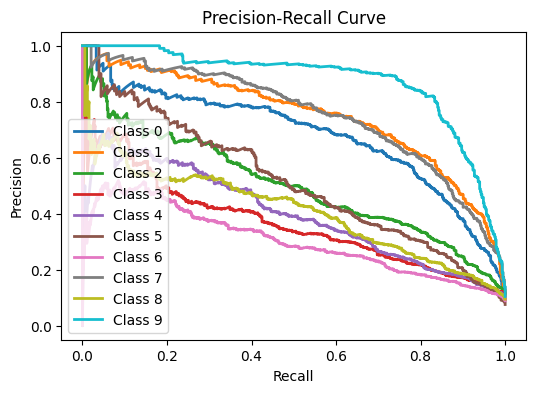

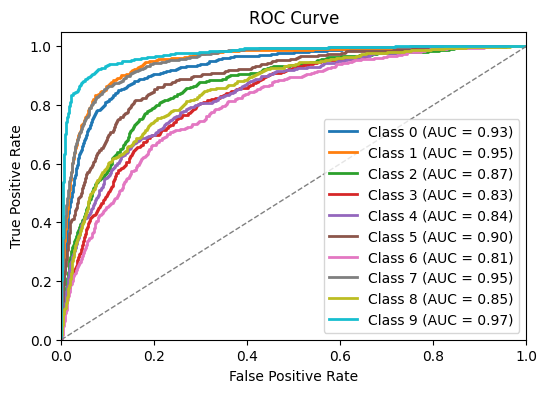

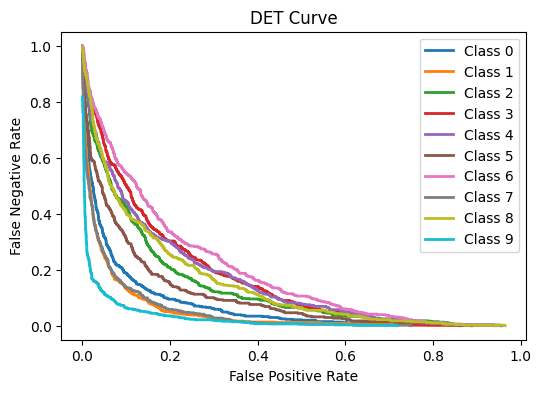

In [ ]:
y_pred = svc_results_holdout.predict_proba(x_test_norm[:, top_features_indices])
plot_precision_recall_curve(y_test, y_pred)
plot_roc_curve(y_test, y_pred)
plot_det_curve(y_test, y_pred)

<span style="font-weight: bold;">Markdown Question:</span> The difficulty in using pearson correlation method for feature selection is determining the appropriate number of features to select. The method described in the module to <span style="font-weight: bold; color: green">automatically choose</span> the appropriate number of features will be computationally very expensive when the number of features is high. <span style="font-weight: bold; color: aqua">Describe an alternative method to reduce the computational complexity of the method discussed in class for datasets with large number of features.</span>  <span style="font-weight: bold;">(150 words)</span>

<span style="font-weight: bold;">Answer:</span> A combination of a heuristic search algorithm like Sequential Forward Search (SFS) and a ranking algorithm can be used to reduce computational complexity. SFS is a wrapper-based algorithm that selects the best features starting from 0. It chooses the best feature to add in each step based on the cross-validation score of the estimator and keeps incrementally adding features to find the right amount. To alleviate the computation risk with SFS when using a high number of features, pre-ranking should be performed so that SFS is performed on the most relevant and non-redundant feature set. This would reduce the number of steps and computational complexity to find the appropriate features.

Alongside the approach, best practices such as early stopping and parallelisation should also be implemented to ensure computationally intensive tasks are performed only when necessary and without using the load of a single machine.

References
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

----------------------------------------------------------------------------------------------------------------------------------------------------------
1. Filter Method - Method described in module is Pearson correlation
2. Wrapper Method [Large no of features, potentially fucked] - Brute force: Select a subset of attributes by assessing performance
3. Embedded Method - Feature selection is part of building a model

Wrapper method automiatically chooses as it goes iteration by iteration finding the best combination, embedded might be better for large datasets

types of wrapper methods
- Exhaistive feature search
- sequential backwards selection (suitable for small number of features and goal is to identify most important features)
- sequential forwards selection

Possible solns -> 1. Identify redundant ones and remove, then based on the relevant features the right ones selected?, 2. Could do Forward Sequential Search - faster than backwards because starting from small, 3. Recursive feature deletion - Among the advantages, we can mention: the ability to drastically reduce the number of features, the ability to adapt to the specific model used, the ability to handle problems with a high number of features and a low number of observations. Among the disadvantages, we can mention: the high computational cost, the risk of overfitting, the dependence on the criterion of importance of the characteristics. 

In [5]:
svc_results_holdout_2 = svc_classifier(x_train_norm[:, top_features_indices], x_test_norm[:, top_features_indices], y_train, y_test, "holdout")


------ Holdout Validation ------
Training Accuracy: 0.5920987654320987
Testing Accuracy: 0.5607407407407408


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# DO ROC CURVE
# Centralise configuration hyperparameters

## References

[1] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

[2] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html